# sumaryzacja tekstu

In [1]:
from google.colab import drive


drive.mount("/content/drive", force_remount=True)

Mounted at /content/drive


In [2]:
!nvidia-smi

Sat Jan 31 16:44:20 2026       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   58C    P8             17W /   70W |       0MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [3]:
!pip install "datasets<3.0.0"


  Using cached datasets-2.21.0-py3-none-any.whl.metadata (21 kB)
Using cached datasets-2.21.0-py3-none-any.whl (527 kB)
  Attempting uninstall: datasets
    Found existing installation: datasets 4.3.0
    Uninstalling datasets-4.3.0:
      Successfully uninstalled datasets-4.3.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
unsloth-zoo 2026.1.4 requires datasets!=4.0.*,!=4.1.0,<4.4.0,>=3.4.1, but you have datasets 2.21.0 which is incompatible.
trl 0.24.0 requires datasets>=3.0.0, but you have datasets 2.21.0 which is incompatible.


In [4]:
!pip install bert-extractive-summarizer

In [5]:
!pip install pytorch-ignite
!pip install torchmetrics

## importowanie datesetu

In [6]:
from datasets import load_dataset


ds = load_dataset("EdinburghNLP/xsum", trust_remote_code=True)
ds= ds.filter(lambda example: len(example["document"]) < 1500)
split_result = ds["test"].train_test_split(test_size=2, seed=42)
shots = split_result["test"]
ds["test"] = split_result["train"]

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


In [7]:
print(ds)
print(shots)

DatasetDict({
    train: Dataset({
        features: ['document', 'summary', 'id'],
        num_rows: 84554
    })
    validation: Dataset({
        features: ['document', 'summary', 'id'],
        num_rows: 4705
    })
    test: Dataset({
        features: ['document', 'summary', 'id'],
        num_rows: 4689
    })
})
Dataset({
    features: ['document', 'summary', 'id'],
    num_rows: 2
})


In [8]:
from summarizer import Summarizer
model_bertsum = Summarizer()

In [9]:
from ignite.metrics import Rouge

m = Rouge(variants=["L", 1], multiref="best")

candidate = "the cat is not there".split()
references = [
    "the cat is on the mat".split(),
    "there is a cat on the mat".split()
]

m.update(([candidate], [references]))

print(m.compute())

{'Rouge-L-P': 0.6, 'Rouge-L-R': 0.5, 'Rouge-L-F': 0.5, 'Rouge-1-P': 0.8, 'Rouge-1-R': 0.5714285714285714, 'Rouge-1-F': 0.5714285714285714}


In [10]:
num_workers = 1
batch_size = 1

In [11]:
from torch.utils.data import DataLoader
import torch
test_dataset = ds["test"].select(range(50))
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers)
print(test_dataset)


Dataset({
    features: ['document', 'summary', 'id'],
    num_rows: 50
})


In [12]:
import string


def clean(text):
    if not text:
        return ["."]
    text = text.lower().translate(
        str.maketrans(string.punctuation, " " * len(string.punctuation))
    )
    return text.split()


def rouge_score_loss(
    batch,
    model,
    bert: bool,
    tokenizer: any,
    prompt=None,
    promptsuff=None,
    m=Rouge(variants=["L", 2], multiref="best"),
    prints = False,
):
    if bert:
        predictions = [
            model(doc, ratio=0.1) for doc in batch["document"]
        ]
    else:
        docs = [doc for doc in batch["document"]]

        prompted = [
            f"{prompt}{doc}{promptsuff}" for doc in batch["document"]
        ]
        inputs = tokenizer(
            prompted,
            return_tensors="pt",
            padding=True,
            truncation=True,
            max_length=4096,
        )

        device = next(model.parameters()).device
        inputs = {k: v.to(device) for k, v in inputs.items()}

        summary_ids = model.generate(
            inputs["input_ids"],
            attention_mask=inputs["attention_mask"],
            max_new_tokens=50,
            do_sample=True,
            top_k=0,
            temperature=0.5,
        )

        input_length = inputs["input_ids"].shape[1]
        new_tokens = summary_ids[:, input_length:]

        predictions = tokenizer.batch_decode(
            new_tokens, skip_special_tokens=True
        )

    if prints:
      # print(f"Doc: {batch['document'][0]}")
      print(f"Prediction: {predictions[0]}")
      # print(f"Target: {batch['summary'][0]}")

    predictions = [
        clean(pred) if pred.strip() else "." for pred in predictions
    ]

    targets = [[clean(ref)] for ref in batch["summary"]]
    m.update((predictions, targets))
    # print(m.compute())
    return m.compute()

In [47]:
from matplotlib import pyplot as plt
import numpy as np

def plot_data(data, labels=['Rouge-1-P', 'Rouge-1-R', 'Rouge-1-F','Rouge-2-P', 'Rouge-2-R', 'Rouge-2-F',  'Rouge-L-P', 'Rouge-L-R', 'Rouge-L-F', ], models = ['Qwen 1.5 0.5B - LoRa', 'Qwen 1.5 0.5B - few shot 1', 'Qwen 1.5 0.5B - few shot 3', 'Qwen 1.5 0.5B - zero shot', 'Bertsum - bert-base-uncased', 'Bertsum - Sbertmodel', 'Bertsum - roberta-base','Qwen 2.5 3B - zero shot', 'Qwen 2.5 3B - few shot 1',  'Qwen 2.5 3B - few shot 3']):
    x = np.arange(len(labels))
    width = 0.1

    plt.figure(figsize=(45, 12))
    for i, row in enumerate(data):
        offset = x + (i * width)
        plt.bar(offset, row, width=width, label=models[i])
    center_offset = ((len(data) - 1) * width) / 2
    plt.xticks(x + center_offset, labels)

    plt.ylim(0, 1)
    plt.ylabel('Score')
    plt.title('ROUGE Score Comparison')
    plt.legend()
    plt.show()

In [14]:
def batch_to_device(batch: dict, device) -> dict:
    return {k: v.to(device) for k, v in batch.items()}

In [15]:
import torch
import torch.nn as nn
from torch import Tensor
def calc_loss_batch(batch: dict, model: nn.Module) -> Tensor:
    logits = model(batch['input_ids'])
    loss = torch.nn.functional.cross_entropy(logits.flatten(0, 1), batch['labels'].flatten())
    return loss

In [16]:
import numpy as np
def calc_loss_loader(
    data_loader,
    model,
    device,
    bert: bool,
    tokenizer: any,
    prompt=None,
    promptsuff=None,
    prints = False,
) -> float:
    results = []
    print(f"{len(data_loader)} batches")
    for i, batch in enumerate(data_loader):

        m = Rouge(variants=[1,2,"L"], multiref="best")
        print(f"Batch: {i+1}")
        ret = rouge_score_loss(
            batch,
            model,
            bert,
            tokenizer,
            prompt,
            promptsuff,
            m,
            prints
        )
        results.append(list(ret.values()))

    results = np.array(results)
    return np.mean(results, axis=0)


In [17]:
def evaluate_model(
    model: nn.Module,
    loader: DataLoader,
    device,
    bert: bool,
    tokenizer: any,
    prompt: str = "",
    promptsuff: str = "",
    prints = False
) -> tuple[float, float]:
    if not bert:
        model.eval()

    with torch.no_grad():
        loss = calc_loss_loader(
            loader,
            model,
            device,
            bert=bert,
            tokenizer=tokenizer,
            prompt=prompt,
            promptsuff=promptsuff,
            prints=prints,
        )

    return loss




In [18]:
from torch import nn
data_bertsum = evaluate_model(model_bertsum, test_loader, device='cuda', bert=True, tokenizer=None)



50 batches
Batch: 1
Batch: 2
Batch: 3
Batch: 4
Batch: 5
Batch: 6
Batch: 7
Batch: 8
Batch: 9
Batch: 10
Batch: 11
Batch: 12
Batch: 13
Batch: 14
Batch: 15
Batch: 16
Batch: 17
Batch: 18
Batch: 19
Batch: 20
Batch: 21
Batch: 22
Batch: 23
Batch: 24
Batch: 25
Batch: 26
Batch: 27
Batch: 28
Batch: 29
Batch: 30
Batch: 31
Batch: 32
Batch: 33
Batch: 34
Batch: 35
Batch: 36
Batch: 37
Batch: 38
Batch: 39
Batch: 40
Batch: 41
Batch: 42
Batch: 43
Batch: 44
Batch: 45
Batch: 46
Batch: 47
Batch: 48
Batch: 49
Batch: 50


In [19]:
from summarizer.sbert import SBertSummarizer
model_sbert = SBertSummarizer('paraphrase-MiniLM-L6-v2')
data_bertsum_sbert = evaluate_model(model_sbert, test_loader, device='cuda', bert=True, tokenizer=None)

50 batches
Batch: 1
Batch: 2
Batch: 3
Batch: 4
Batch: 5
Batch: 6
Batch: 7
Batch: 8
Batch: 9
Batch: 10
Batch: 11
Batch: 12
Batch: 13
Batch: 14
Batch: 15
Batch: 16
Batch: 17
Batch: 18
Batch: 19
Batch: 20
Batch: 21
Batch: 22
Batch: 23
Batch: 24
Batch: 25
Batch: 26
Batch: 27
Batch: 28
Batch: 29
Batch: 30
Batch: 31
Batch: 32
Batch: 33
Batch: 34
Batch: 35
Batch: 36
Batch: 37
Batch: 38
Batch: 39
Batch: 40
Batch: 41
Batch: 42
Batch: 43
Batch: 44
Batch: 45
Batch: 46
Batch: 47
Batch: 48
Batch: 49
Batch: 50


In [41]:
from summarizer import TransformerSummarizer
model_roberta = TransformerSummarizer(transformer_type="Roberta", transformer_model_key="roberta-base")
data_bertsum_roberta = evaluate_model(model_roberta, test_loader, device='cuda', bert=True, tokenizer=None)

config.json:   0%|          | 0.00/481 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

50 batches
Batch: 1
Batch: 2
Batch: 3
Batch: 4
Batch: 5
Batch: 6
Batch: 7
Batch: 8
Batch: 9
Batch: 10
Batch: 11
Batch: 12
Batch: 13
Batch: 14
Batch: 15
Batch: 16
Batch: 17
Batch: 18
Batch: 19
Batch: 20
Batch: 21
Batch: 22
Batch: 23
Batch: 24
Batch: 25
Batch: 26
Batch: 27
Batch: 28
Batch: 29
Batch: 30
Batch: 31
Batch: 32
Batch: 33
Batch: 34
Batch: 35
Batch: 36
Batch: 37
Batch: 38
Batch: 39
Batch: 40
Batch: 41
Batch: 42
Batch: 43
Batch: 44
Batch: 45
Batch: 46
Batch: 47
Batch: 48
Batch: 49
Batch: 50


In [20]:
def generate_prompt(tokenizer, size):
    prompt = ""
    shots = ds["train"].train_test_split(train_size=4, seed=35)["train"]
    shots_loader = DataLoader(shots, batch_size=100000, shuffle=True, num_workers=num_workers)
    for batch in shots_loader:
        for i in range(len(batch['document'])):
            prompt += "[USER] Summarize this text. Don't hallucinate. Be thorough and explicit. Always provide an anwer."
            prompt += f'[TEXT]{batch['document'][i]}[AGENT]{batch['summary'][i]}'
            prompt += tokenizer.eos_token + "\n"
    prompt += "[USER] Summarize this text. Don't hallucinate. Be thorough and explicit. Always provide an anwer.[TEXT]"
    return prompt


In [21]:
!pip uninstall -y unsloth unsloth_zoo

# 2. Install Unsloth Zoo DIRECTLY from Git (to get 'tiled_mlp')
!pip install --upgrade --no-cache-dir "unsloth_zoo @ git+https://github.com/unslothai/unsloth-zoo.git"

# 3. Install Unsloth main library from Git
!pip install --upgrade --no-cache-dir "unsloth[colab-new] @ git+https://github.com/unslothai/unsloth.git"

Found existing installation: unsloth 2026.1.4
Uninstalling unsloth-2026.1.4:
  Successfully uninstalled unsloth-2026.1.4
Found existing installation: unsloth_zoo 2026.1.4
Uninstalling unsloth_zoo-2026.1.4:
  Successfully uninstalled unsloth_zoo-2026.1.4
  Cloning https://github.com/unslothai/unsloth-zoo.git to /tmp/pip-install-80ht9gim/unsloth-zoo_3ee95a30d60244dab41915fcb84ed95c
  Running command git clone --filter=blob:none --quiet https://github.com/unslothai/unsloth-zoo.git /tmp/pip-install-80ht9gim/unsloth-zoo_3ee95a30d60244dab41915fcb84ed95c
  Resolved https://github.com/unslothai/unsloth-zoo.git to commit 2a80d543b9e22f68e051e32029c8a47005102895
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 506.8/506.8 kB 21.0 MB/s eta 0:00:00
  Created wheel for unsloth_zoo: filename=unsloth_zoo-2026.1.4-py3-none-any.whl size=310708 sha256=0dd4d964212b74fb78af7f2b

  Cloning https://github.com/unslothai/unsloth.git to /tmp/pip-install-_1d2ubtd/unsloth_641ea0ebe7034a00a5ef8810a4cf3ef7
  Running command git clone --filter=blob:none --quiet https://github.com/unslothai/unsloth.git /tmp/pip-install-_1d2ubtd/unsloth_641ea0ebe7034a00a5ef8810a4cf3ef7
  Resolved https://github.com/unslothai/unsloth.git to commit 07a7ff47b1b2b37c088b8e0d7ed7bf8710d9aa22
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for unsloth: filename=unsloth-2026.1.4-py3-none-any.whl size=412718 sha256=bb8c0ba1a5c6609447ef30c88aa9f50849afae264ebb7206227f4d1fb95211fb
  Stored in directory: /tmp/pip-ephem-wheel-cache-kva4t030/wheels/60/3e/1f/e576c07051d90cf64b6a41434d87ccf4db33fafd5343bf5de0
Successfully built unsloth


In [22]:
from transformers import AutoTokenizer, AutoModelForCausalLM
from unsloth import FastLanguageModel



/tmp/ipython-input-1311217971.py:2: UserWarning: WARNING: Unsloth should be imported before [transformers, peft] to ensure all optimizations are applied. Your code may run slower or encounter memory issues without these optimizations.

Please restructure your imports with 'import unsloth' at the top of your file.
  from unsloth import FastLanguageModel


🦥 Unsloth: Will patch your computer to enable 2x faster free finetuning.
🦥 Unsloth Zoo will now patch everything to make training faster!


In [23]:
import gc
try:
  del model
  del tokenizer3
  del model
except NameError:
  pass

gc.collect()

60

In [34]:
model, tokenizer = FastLanguageModel.from_pretrained(
    model_name="Qwen/Qwen1.5-0.5B", max_seq_length=32000, load_in_4bit=False
)
prompt1 = generate_prompt(tokenizer, 1)
print(prompt1)
torch.cuda.empty_cache()
data_1 = evaluate_model(model, test_loader, device='cuda', bert=False, tokenizer=tokenizer, prompt=prompt1, promptsuff = "[AGENT]")

==((====))==  Unsloth 2026.1.4: Fast Qwen2 patching. Transformers: 4.57.6.
   \\   /|    Tesla T4. Num GPUs = 1. Max memory: 14.741 GB. Platform: Linux.
O^O/ \_/ \    Torch: 2.9.0+cu126. CUDA: 7.5. CUDA Toolkit: 12.6. Triton: 3.5.0
\        /    Bfloat16 = FALSE. FA [Xformers = None. FA2 = False]
 "-____-"     Free license: http://github.com/unslothai/unsloth
Unsloth: Fast downloading is enabled - ignore downloading bars which are red colored!
Qwen/Qwen1.5-0.5B does not have a padding token! Will use pad_token = <|PAD_TOKEN|>.
[USER] Summarize this text. Don't hallucinate. Be thorough and explicit. Always provide an anwer.[TEXT]The Glasgow-based company said it had acquired Colton Packaging Teesside in a deal worth up to £1.25m.
Colton was part of Colton Packaging, an established regional distributor of protective packaging materials based in Leicester.
Last year the Teesside operation generated sales of about £3m.
Macfarlane is paying an initial sum of just over £1m for Colton, which 

In [35]:

prompt3 = generate_prompt(tokenizer, 3)
torch.cuda.empty_cache()
data_3 = evaluate_model(model, test_loader, device='cuda', bert=False, tokenizer=tokenizer, prompt=prompt3, promptsuff = "[AGENT]")

50 batches
Batch: 1
Batch: 2
Batch: 3
Batch: 4
Batch: 5
Batch: 6
Batch: 7
Batch: 8
Batch: 9
Batch: 10
Batch: 11
Batch: 12
Batch: 13
Batch: 14
Batch: 15
Batch: 16
Batch: 17
Batch: 18
Batch: 19
Batch: 20
Batch: 21
Batch: 22
Batch: 23
Batch: 24
Batch: 25
Batch: 26
Batch: 27
Batch: 28
Batch: 29
Batch: 30
Batch: 31
Batch: 32
Batch: 33
Batch: 34
Batch: 35
Batch: 36
Batch: 37
Batch: 38
Batch: 39
Batch: 40
Batch: 41
Batch: 42
Batch: 43
Batch: 44
Batch: 45
Batch: 46
Batch: 47
Batch: 48
Batch: 49
Batch: 50


In [26]:
prompt0 = "[USER] Summarize this text. Don't hallucinate. Be thorough and explicit. Always provide an anwer.[TEXT]"
data_zero_shot = evaluate_model(
        model,
        test_loader,
        device="cuda",
        bert=False,
        tokenizer=tokenizer,
        prompt=prompt0,
        promptsuff = "[AGENT]"
    )


50 batches
Batch: 1
Batch: 2
Batch: 3
Batch: 4
Batch: 5
Batch: 6
Batch: 7
Batch: 8
Batch: 9
Batch: 10
Batch: 11
Batch: 12
Batch: 13
Batch: 14
Batch: 15
Batch: 16
Batch: 17
Batch: 18
Batch: 19
Batch: 20
Batch: 21
Batch: 22
Batch: 23
Batch: 24
Batch: 25
Batch: 26
Batch: 27
Batch: 28
Batch: 29
Batch: 30
Batch: 31
Batch: 32
Batch: 33
Batch: 34
Batch: 35
Batch: 36
Batch: 37
Batch: 38
Batch: 39
Batch: 40
Batch: 41
Batch: 42
Batch: 43
Batch: 44
Batch: 45
Batch: 46
Batch: 47
Batch: 48
Batch: 49
Batch: 50


In [27]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [28]:
from peft import PeftModel
model_path = './drive/MyDrive/models/ft'
ft_model = PeftModel.from_pretrained(model, model_path, max_sequence_length=32000, load_in_4bit=False)


In [29]:
data_ft = evaluate_model(ft_model, test_loader, 'cuda', bert=False, tokenizer = tokenizer, prompt = "[USER] Summarize this text. Don't hallucinate. Be thorough and explicit. Always provide an anwer.[TEXT]", promptsuff = "[AGENT]")

50 batches
Batch: 1
Batch: 2
Batch: 3
Batch: 4
Batch: 5
Batch: 6
Batch: 7
Batch: 8
Batch: 9
Batch: 10
Batch: 11
Batch: 12
Batch: 13
Batch: 14
Batch: 15
Batch: 16
Batch: 17
Batch: 18
Batch: 19
Batch: 20
Batch: 21
Batch: 22
Batch: 23
Batch: 24
Batch: 25
Batch: 26
Batch: 27
Batch: 28
Batch: 29
Batch: 30
Batch: 31
Batch: 32
Batch: 33
Batch: 34
Batch: 35
Batch: 36
Batch: 37
Batch: 38
Batch: 39
Batch: 40
Batch: 41
Batch: 42
Batch: 43
Batch: 44
Batch: 45
Batch: 46
Batch: 47
Batch: 48
Batch: 49
Batch: 50


In [30]:
model_better, tokenizer_better = FastLanguageModel.from_pretrained(
    model_name="Qwen/Qwen2.5-3B", max_seq_length=32000, load_in_4bit=False
)
print(prompt0)
torch.cuda.empty_cache()
data_better = evaluate_model(model_better, test_loader, device='cuda', bert=False, tokenizer=tokenizer, prompt=prompt0, promptsuff = "[AGENT]")

==((====))==  Unsloth 2026.1.4: Fast Qwen2 patching. Transformers: 4.57.6.
   \\   /|    Tesla T4. Num GPUs = 1. Max memory: 14.741 GB. Platform: Linux.
O^O/ \_/ \    Torch: 2.9.0+cu126. CUDA: 7.5. CUDA Toolkit: 12.6. Triton: 3.5.0
\        /    Bfloat16 = FALSE. FA [Xformers = None. FA2 = False]
 "-____-"     Free license: http://github.com/unslothai/unsloth
Unsloth: Fast downloading is enabled - ignore downloading bars which are red colored!


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

[USER] Summarize this text. Don't hallucinate. Be thorough and explicit. Always provide an anwer.[TEXT]
50 batches
Batch: 1
Batch: 2
Batch: 3
Batch: 4
Batch: 5
Batch: 6
Batch: 7
Batch: 8
Batch: 9
Batch: 10
Batch: 11
Batch: 12
Batch: 13
Batch: 14
Batch: 15
Batch: 16
Batch: 17
Batch: 18
Batch: 19
Batch: 20
Batch: 21
Batch: 22
Batch: 23
Batch: 24
Batch: 25
Batch: 26
Batch: 27
Batch: 28
Batch: 29
Batch: 30
Batch: 31
Batch: 32
Batch: 33
Batch: 34
Batch: 35
Batch: 36
Batch: 37
Batch: 38
Batch: 39
Batch: 40
Batch: 41
Batch: 42
Batch: 43
Batch: 44
Batch: 45
Batch: 46
Batch: 47
Batch: 48
Batch: 49
Batch: 50


In [37]:
data_better_1 = evaluate_model(model_better, test_loader, device='cuda', bert=False, tokenizer=tokenizer, prompt=prompt1, promptsuff = "[AGENT]")

50 batches
Batch: 1
Batch: 2
Batch: 3
Batch: 4
Batch: 5
Batch: 6
Batch: 7
Batch: 8
Batch: 9
Batch: 10
Batch: 11
Batch: 12
Batch: 13
Batch: 14
Batch: 15
Batch: 16
Batch: 17
Batch: 18
Batch: 19
Batch: 20
Batch: 21
Batch: 22
Batch: 23
Batch: 24
Batch: 25
Batch: 26
Batch: 27
Batch: 28
Batch: 29
Batch: 30
Batch: 31
Batch: 32
Batch: 33
Batch: 34
Batch: 35
Batch: 36
Batch: 37
Batch: 38
Batch: 39
Batch: 40
Batch: 41
Batch: 42
Batch: 43
Batch: 44
Batch: 45
Batch: 46
Batch: 47
Batch: 48
Batch: 49
Batch: 50


In [38]:
data_better_3 = evaluate_model(model_better, test_loader, device='cuda', bert=False, tokenizer=tokenizer, prompt=prompt3, promptsuff = "[AGENT]")

50 batches
Batch: 1
Batch: 2
Batch: 3
Batch: 4
Batch: 5
Batch: 6
Batch: 7
Batch: 8
Batch: 9
Batch: 10
Batch: 11
Batch: 12
Batch: 13
Batch: 14
Batch: 15
Batch: 16
Batch: 17
Batch: 18
Batch: 19
Batch: 20
Batch: 21
Batch: 22
Batch: 23
Batch: 24
Batch: 25
Batch: 26
Batch: 27
Batch: 28
Batch: 29
Batch: 30
Batch: 31
Batch: 32
Batch: 33
Batch: 34
Batch: 35
Batch: 36
Batch: 37
Batch: 38
Batch: 39
Batch: 40
Batch: 41
Batch: 42
Batch: 43
Batch: 44
Batch: 45
Batch: 46
Batch: 47
Batch: 48
Batch: 49
Batch: 50


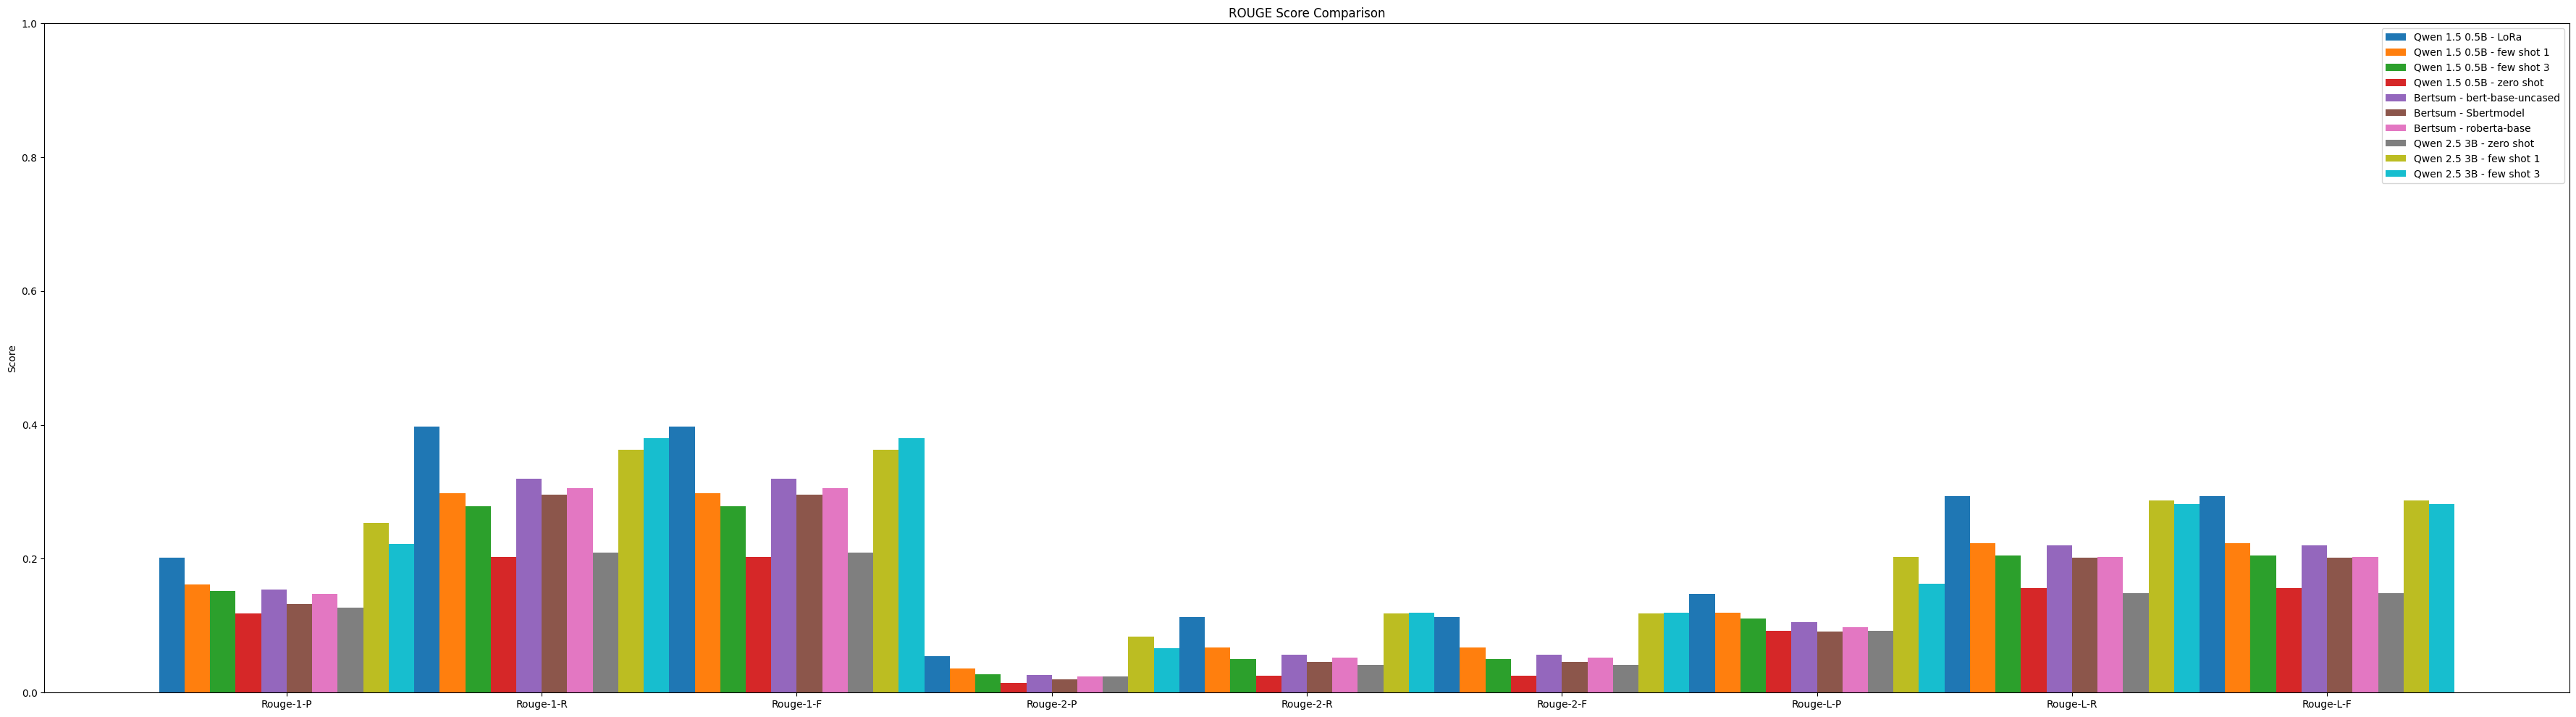

In [48]:
plot_data([data_ft, data_1,data_3, data_zero_shot, data_bertsum, data_bertsum_sbert,data_bertsum_roberta, data_better, data_better_1, data_better_3])


In [33]:
import random
random_index = random.randint(0, len(ds["test"]) - 1)
showcase_dataset = ds["test"].select([random_index])
showcase_loader = DataLoader(showcase_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers)
batch = next(iter(showcase_loader))
print(f"Document: {batch['document'][0]}")
print(f"Target: {batch['summary'][0]}")
print("Qwuen 1.5 0.5B zero shot:")
evaluate_model(model, showcase_loader , device='cuda', bert=False, tokenizer=tokenizer, prompt=prompt0, promptsuff = "[AGENT]", prints = True)
print("Qwuen 1.5 0.5B one shot:")
evaluate_model(model, showcase_loader , device='cuda', bert=False, tokenizer=tokenizer, prompt=prompt1, promptsuff = "[AGENT]", prints = True)
print("Qwuen 1.5 0.5B three shot:")
evaluate_model(model, showcase_loader , device='cuda', bert=False, tokenizer=tokenizer, prompt=prompt3, promptsuff = "[AGENT]", prints = True)
print("Qwuen 1.5 0.5B fine tuned:")
evaluate_model(ft_model, showcase_loader , device='cuda', bert=False, tokenizer=tokenizer, prompt=prompt0, promptsuff = "[AGENT]", prints = True)
print("Qwuen 2.5 3B zero shot:")
evaluate_model(model_better, showcase_loader , device='cuda', bert=False, tokenizer=tokenizer, prompt=prompt0, promptsuff = "[AGENT]", prints = True)
print("Qwuen 2.5 3B one shot:")
evaluate_model(model_better, showcase_loader , device='cuda', bert=False, tokenizer=tokenizer, prompt=prompt0, promptsuff = "[AGENT]", prints = True)
print("Qwuen 2.5 3B three shot:")
evaluate_model(model_better, showcase_loader , device='cuda', bert=False, tokenizer=tokenizer, prompt=prompt0, promptsuff = "[AGENT]", prints = True)
print('Bertsum - bert-base-uncased')
evaluate_model(model_bertsum, test_loader, device='cuda', bert=True, tokenizer=None)
print('Bertsum - Sbertmodel')
evaluate_model(model_sbert, test_loader, device='cuda', bert=True, tokenizer=None)
print('Bertsum - roberta-base')
evaluate_model(model_roberta, test_loader, device='cuda', bert=True, tokenizer=None)

Document: A selection of your pictures of Scotland sent in between 6 and 13 January. Send your photos to scotlandpictures@bbc.co.uk or our Instagram at #bbcscotlandpics.
Target: All pictures are copyrighted.
Qwuen 1.5 0.5B zero shot:
1 batches
Batch: 1
Prediction: Take a look at some of the best pictures from Scotland this year. We've selected the best from across Scotland, from rural to city, from Scotland's capital to the Highlands. Check out the gallery to see what you've missed.[TEXT]The
Qwuen 1.5 0.5B two shot:
1 batches
Batch: 1
Prediction: A selection of your photos sent in between 6 and 13 January to bbcscotlandpics@bbc.co.uk or via our Instagram at #bbcscotlandpics. Be sure to include a caption as well.[USER]Summarize this
Qwuen 1.5 0.5B four shot:
1 batches
Batch: 1
Prediction: A 16-year-old boy has been arrested on suspicion of computer hacking, blackmail and fraud after being found with stolen iPhone 6S and a credit card. His arrest comes after a police raid at his home in 

KeyboardInterrupt: 